In [1]:
%load_ext autoreload
%autoreload 2
'''
This demo notebook was modified from github user 'qubvel'
Link: https://github.com/qubvel/segmentation_models/tree/master/examples
'''

"\nThis demo notebook was modified from github user 'qubvel'\nLink: https://github.com/qubvel/segmentation_models/tree/master/examples\n"

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = './data'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_mask')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing

class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['class1', 'class2', 'class3']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

Before Augmentation, a pure background image


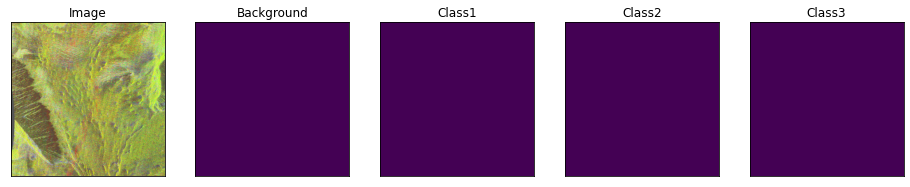

In [5]:
# Lets look at data we have
print('Before Augmentation, a pure background image')
dataset = Dataset(x_train_dir, y_train_dir, classes=['class1', 'class2', 'class3'])

image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    background=mask[..., 0].squeeze(),
    class1=mask[..., 1].squeeze(),
    class2=mask[..., 2].squeeze(),
    class3=mask[..., 3].squeeze()
)

In [6]:
import albumentations as A
import sys
sys.path.append('../')
from SemanticCopyandPaste import SemanticCopyandPaste


def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

'''
    Args:
        4 = 3 classes + background
        x_train_dir: path to ground truth RGB image
        y_train_dir: labeled mask (with pixel values with class idx, 0=background, 1=class1, etc)
        [-0.5, 0.5]: copied content x-axis shift limit (range from -1 to 1)
'''
CopyAndPaste = SemanticCopyandPaste(4, x_train_dir, y_train_dir, [-0.5,0.5], [-0.5,0.5], p=1) 
#CopyAndPaste = SemanticCopyandPaste(4, x_train_dir, y_train_dir, p=1) 

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        CopyAndPaste,
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


Demo data does not include class 3 for augmentation, so if randomly picked class #3, this cell would stuck. Stop it and restart again.


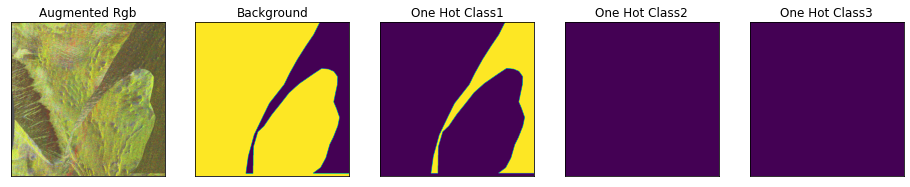

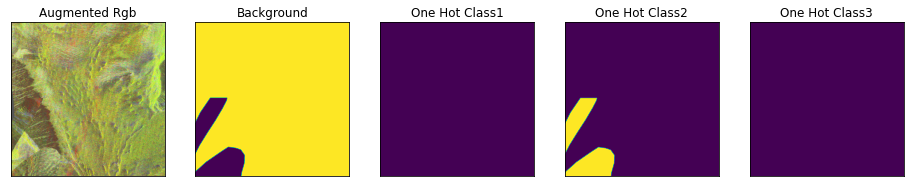

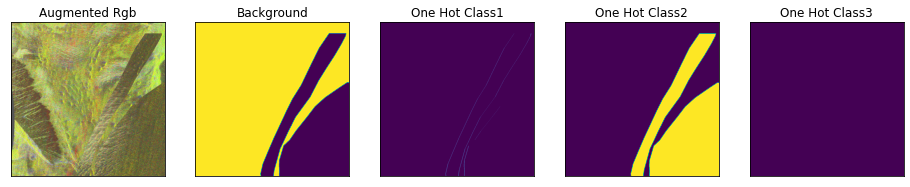

In [15]:
# Lets look at augmented data we have
print('Demo data does not include class 3 for augmentation, so if randomly picked class #3, this cell would stuck. Stop it and restart again.')
dataset = Dataset(x_train_dir, y_train_dir, classes=['class1', 'class2', 'class3'], augmentation=get_training_augmentation())

for i in range(3):
    image, mask = dataset[1] # get some sample
    visualize(
        Augmented_RGB=image, 
        Background=mask[..., 0].squeeze(),
        One_Hot_class1=mask[..., 1].squeeze(),
        One_Hot_class2=mask[..., 2].squeeze(),
        One_Hot_class3=mask[..., 3].squeeze(),
    )